In [25]:
import sys
sys.path.append('../mlai_research/')
import log
import utils
import cv2
import rasterio
import rasterio.plot
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import reproject, Resampling
from shapely.geometry import box, mapping
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import geopandas as gpd
from PIL import Image

In [4]:
logger = log.get_logger(__name__)

In [5]:
def load_data(conf):
    imgs = {}
    # 10 bands of Advanced Camera image (multispectral)
    # 3 bands of Normal Camera image
    # 1 band of Digital Surface Model
    # 1 band of Digital Terrain Model
    imgs["hyps"] = utils.load_raster(f"{conf.data.path_base_hyps}{conf.data.fn_hyps}")
    imgs["rgba"] = utils.load_raster(f"{conf.data.path_base_rgba}{conf.data.fn_rgba}")
    imgs["dsm"] = utils.load_raster(f"{conf.data.path_base_dsm}{conf.data.fn_dsm}")
    imgs["dtm"] = utils.load_raster(f"{conf.data.path_base_dtm}{conf.data.fn_dtm}")
    # Load shapefile
    gdf = gpd.read_file(f"{conf.data.path_base_points}{conf.data.fn_shp_combined}")
    return imgs, gdf



def get_bbox(imgs: dict):
    box1 = box(*imgs["hyps"].bounds)
    box2 = box(*imgs["rgba"].bounds)
    box3 = box(*imgs["dsm"].bounds)
    box4 = box(*imgs["dtm"].bounds)

    intersect = box1.intersection(box2)
    intersect = intersect.intersection(box3)
    intersect = intersect.intersection(box4)
    return intersect


def clip_raster_to_bounds(name, path_int, raster, target_bounds):
    # Create a polygon from the target bounds
    target_polygon = box(*target_bounds)

    # Clip the raster using the target polygon
    clipped_data, clipped_transform = mask(raster, [target_polygon], crop=True)

    # Update the raster metadata
    clipped_meta = raster.meta.copy()
    clipped_meta.update({
        'transform': clipped_transform,
        'height': clipped_data.shape[1],
        'width': clipped_data.shape[2]
    })

    # Create a new raster dataset with the clipped data and metadata
    with rasterio.open(f"{path_int}{name}.tif", "w", **clipped_meta) as dst:
        dst.write(clipped_data)

    # Return the clipped raster dataset
    clipped_raster = rasterio.open(f"{path_int}{name}.tif")
    logger.info(f"{clipped_raster.transform}")
    return clipped_raster


def align_rasters(name, path_int, src_raster, ref_raster):
    profile = ref_raster.profile.copy()
    aligned_data = []

    for i in range(1, src_raster.count + 1):
        src_data = src_raster.read(i)
        ref_data = np.empty((ref_raster.height, ref_raster.width), dtype=src_data.dtype)
        reproject(
            src_data,
            ref_data,
            src_transform=src_raster.transform,
            src_crs=src_raster.crs,
            dst_transform=ref_raster.transform,
            dst_crs=ref_raster.crs,
            resampling=Resampling.nearest
        )
        aligned_data.append(ref_data)

    profile.update(count=len(aligned_data))

    with rasterio.open(f"{path_int}{name}.tif", "w", **profile) as dst:
        for i, data in enumerate(aligned_data, start=1):
            dst.write(data, i)

    aligned_raster = rasterio.open(f"{path_int}{name}.tif")
    logger.info(f"{aligned_raster.transform}")
    return aligned_raster


def clip_gdf(gdf, bounds):
    clipped_gdf = gdf[
        (gdf.geometry.x > bounds.left) & 
        (gdf.geometry.x < bounds.right) &
        (gdf.geometry.y > bounds.bottom) &
        (gdf.geometry.y < bounds.top)
    ]
    logger.info(f"Original gdf: {gdf.shape}")
    logger.info(f"Clipped gdf: {clipped_gdf.shape}")
    logger.info(f"Species split: {clipped_gdf.Species.value_counts()}")
    return clipped_gdf


@utils.timer
def plot_raster(gdf, rasterimg, raster_type, out_dir=None, fn=None, show=False):
    fig, ax = plt.subplots(figsize = (20,20))
    
    # if raster_type == 'rgba':
    #     cmap = "Set2"
    if raster_type == 'hyps':
        cmap = "Set2"
    elif raster_type == 'dsm' or raster_type == 'dtm':
        cmap = "terrain" #"terrain"

    gdf.plot(column='Species',
                   categorical=True,
                   legend=True,
                   cmap="Set2",
                   ax=ax,
            aspect=1)
    ax.set_title("Letaba Points (Area of Interest 1)")
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.pid):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    if show == True:
        rasterio.plot.show(rasterimg, ax=ax, cmap=cmap)
    else:
        utils.save_plot(fig, f"{out_dir}preprocessed_{fn}.png")
        logger.info(f"Saved plot to {out_dir}preprocessed_{fn}.png")


def process_shp(clipped_gdf, buffer=10):
    gdf_copy = clipped_gdf.copy()
    gdf_copy['buffer'] = gdf_copy.buffer(buffer)
    return gdf_copy


def save_as_png(image: np.ndarray, filename: str):
    """
    Saves the input image as a PNG file.

    Parameters:
    - image (numpy.ndarray): The input image.
    - filename (str): The output filename.
    """
    im = Image.fromarray((image * 255).astype(np.uint8))
    im.save(filename)


def save_crop(path_int_cr_tif, pid, raster_type, label, out_image, out_meta):
    resized_img = np.resize(out_image, (out_image.shape[0], 87, 87))

    # Update the metadata with the new dimensions
    out_meta.update({"height": 87, "width": 87})

    # Save the resized raster data
    with rasterio.open(f"{path_int_cr_tif}{pid}_{raster_type}_{label}.tif", "w", **out_meta) as dst:
        dst.write(resized_img)


def save_crop_rgb(path_int_cr_tif, pid, raster_type, label, out_image, out_meta, path_int_cr_imgs):
    with rasterio.open(f"{path_int_cr_tif}{pid}_{raster_type}_{label}.tif", "w", **out_meta) as dst:
        dst.write(out_image)
    
    # Normalize and convert to RGB
    cropped_raster = rasterio.open(f"{path_int_cr_tif}{pid}_{raster_type}_{label}.tif")
    rgb_data_hwc = convert_to_rgb(cropped_raster)
    normalized_image = normalize_image(rgb_data_hwc)
    resized_img = crop_image(normalized_image, (87, 87))
    # Save as PNG
    logger.info(f'Resized image shape: {resized_img.shape}')
    save_as_png(resized_img, f"{path_int_cr_imgs}{pid}_{raster_type}_{label}.png")


def crop_image(image: np.ndarray, new_shape: tuple) -> np.ndarray:
    """
    Crops the input image to the specified shape.

    Parameters:
    - image (numpy.ndarray): The input image.
    - new_shape (tuple): The desired shape.

    Returns:
    - numpy.ndarray: The cropped image.
    """
    # Ensure the new shape is smaller than the current shape
    # assert all(new <= curr for new, curr in zip(new_shape, image.shape)), "New shape must be smaller than current shape"

    # add condition to check if new_shape is smaller than image.shape
    if new_shape[0] < image.shape[0] or new_shape[1] < image.shape[1]:
        # Slice the image to the new shape
        cropped_image = cv2.resize(image, new_shape)
        return cropped_image
    else:
        return image
    

def equalize_histogram(image: np.ndarray) -> np.ndarray:
    """
    Equalizes the histogram of the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The image with equalized histogram.
    """
    # Normalize the image to 0-1 range
    # image_norm = (image - np.min(image)) / (np.max(image) - np.min(image))

    # # Convert the normalized image to 8-bit
    # image_8bit = np.uint8(image_norm * 255)

    image_8bit = normalize_image(image)

    # Flatten the image into 1D array
    image_flattened = image_8bit.flatten()

    # Perform histogram equalization
    equalized_image = cv2.equalizeHist(image_flattened)

    # Reshape the equalized image back to the original shape
    equalized_image = equalized_image.reshape(image.shape)

    return equalized_image


def save_crop_digital_model(path_int_cr_tif, pid, raster_type, label, out_image, out_meta, path_int_cr_imgs):
    with rasterio.open(f"{path_int_cr_tif}{pid}_{raster_type}_{label}.tif", "w", **out_meta) as dst:
        dst.write(out_image)
    
    # Normalize and convert to RGB
    equalized_img = equalize_histogram(out_image[0])
    # resized_img = cv2.resize(equalized_img, (89, 89))
    resized_img = crop_image(equalized_img, (87, 87))
    # Save as PNG
    logger.info(f'Padded image shape: {resized_img.shape}')
    save_as_png(resized_img, f"{path_int_cr_imgs}{pid}_{raster_type}_{label}.png")
    return resized_img



def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalizes the pixel values of the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The normalized image.
    """
    # Normalize the image to the range [0, 255]
    # normalized_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # return normalized_image
    normalized_image = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255
    return normalized_image.astype(np.uint8)

def convert_to_rgb(rgba_aligned):
    # Read the raster bands directly into numpy arrays.
    rgba_data = rgba_aligned.read()
    rgb_data = rgba_data[:3, :, :]
    rgb_data_hwc = np.transpose(rgb_data, (1, 2, 0))
    return rgb_data_hwc


def save_crop_chm(dsm, dtm, pid, raster_type, label, path_int_cr_imgs):
    ndsm = dsm - dtm
    save_as_png(ndsm, f"{path_int_cr_imgs}{pid}_{raster_type}_{label}.png")


def crop_buffer(raster, polygon):
    geojson_polygon = mapping(polygon)
    out_image, out_transform = mask(raster, [geojson_polygon], crop=True)
    out_meta = raster.meta.copy()
    out_meta.update({"height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})
    return out_image, out_meta

@utils.timer
def create_cropped_data(clipped_gdf, conf,
                     rgb, ms_aligned, dsm_aligned, dtm_aligned):
    gdf_copy = process_shp(clipped_gdf, buffer=conf.preprocess.crop_buffer)
    for _, row in gdf_copy.iterrows():
        rgb_img, rgb_img_meta = crop_buffer(rgb, row.buffer)
        save_crop_rgb(conf.data.path_int_cr_tif, row.pid, 'rgb', row.Species, rgb_img, rgb_img_meta, conf.data.path_int_cr_img)
        hyps_img, hyps_img_meta = crop_buffer(ms_aligned, row.buffer)
        save_crop(conf.data.path_int_cr_tif, row.pid, 'hyps', row.Species, hyps_img, hyps_img_meta)
        dsm_img, dsm_img_meta = crop_buffer(dsm_aligned, row.buffer)
        resized_dsm = save_crop_digital_model(conf.data.path_int_cr_tif, row.pid, 'dsm', row.Species, dsm_img, dsm_img_meta, conf.data.path_int_cr_img)
        dtm_img, dtm_img_meta = crop_buffer(dtm_aligned, row.buffer)
        resized_dtm = save_crop_digital_model(conf.data.path_int_cr_tif, row.pid, 'dtm', row.Species, dtm_img, dtm_img_meta, conf.data.path_int_cr_img)
        save_crop_chm(resized_dsm, resized_dtm, row.pid, 'chm', row.Species, conf.data.path_int_cr_img)

In [6]:
conf = utils.load_config("base")
imgs, gdf = load_data(conf)

22-Dec-23 18:21:56 - INFO - Starting 'load_config'.
22-Dec-23 18:21:56 - INFO - Finished 'load_config' in 0.0226 secs.
22-Dec-23 18:21:56 - INFO - Loaded image: ../data/01_base/hyps_7cm_resampled/hyps_aoi_1.tif
22-Dec-23 18:21:56 - INFO - Image channels: 10
22-Dec-23 18:21:56 - INFO - Image size: 22378x23466
22-Dec-23 18:21:56 - INFO - Image crs: EPSG:32736
22-Dec-23 18:21:56 - INFO - Image bounds: BoundingBox(left=362292.84996986337, bottom=7356585.982265749, right=363843.95866186335, top=7358212.504589749)
22-Dec-23 18:21:56 - INFO - Image transform: | 0.07, 0.00, 362292.85|
| 0.00,-0.07, 7358212.50|
| 0.00, 0.00, 1.00|
22-Dec-23 18:21:56 - INFO - Loaded image: ../data/01_base/rgba_7cm/rgba_aoi_1.tif
22-Dec-23 18:21:56 - INFO - Image channels: 4
22-Dec-23 18:21:56 - INFO - Image size: 22379x23468
22-Dec-23 18:21:56 - INFO - Image crs: EPSG:32736
22-Dec-23 18:21:56 - INFO - Image bounds: BoundingBox(left=362292.7879142576, bottom=7356585.87461337, right=363843.97933615686, top=7358212

In [7]:
intersecting_box = get_bbox(imgs)
target_bounds = intersecting_box.bounds

In [8]:
rgba_clipped = clip_raster_to_bounds('rgba', conf.data.path_int_cl, imgs['rgba'], target_bounds)
hyps_clipped = clip_raster_to_bounds('hyps', conf.data.path_int_cl, imgs['hyps'], target_bounds)
dsm_clipped = clip_raster_to_bounds('dsm', conf.data.path_int_cl, imgs['dsm'], target_bounds)
dtm_clipped = clip_raster_to_bounds('dtm', conf.data.path_int_cl, imgs['dtm'], target_bounds)

22-Dec-23 18:22:10 - INFO - | 0.07, 0.00, 362292.79|
| 0.00,-0.07, 7358212.41|
| 0.00, 0.00, 1.00|
22-Dec-23 18:22:36 - INFO - | 0.07, 0.00, 362292.85|
| 0.00,-0.07, 7358212.37|
| 0.00, 0.00, 1.00|
22-Dec-23 18:22:43 - INFO - | 0.07, 0.00, 362292.79|
| 0.00,-0.07, 7358212.35|
| 0.00, 0.00, 1.00|
22-Dec-23 18:22:50 - INFO - | 0.07, 0.00, 362292.79|
| 0.00,-0.07, 7358212.35|
| 0.00, 0.00, 1.00|


In [9]:
hyps_aligned = align_rasters('hyps', conf.data.path_int_al, hyps_clipped, rgba_clipped)
dsm_aligned = align_rasters('dsm', conf.data.path_int_al, dsm_clipped, rgba_clipped)
dtm_aligned = align_rasters('dtm', conf.data.path_int_al, dtm_clipped, rgba_clipped)

22-Dec-23 18:24:45 - INFO - | 0.07, 0.00, 362292.79|
| 0.00,-0.07, 7358212.41|
| 0.00, 0.00, 1.00|
22-Dec-23 18:24:52 - INFO - | 0.07, 0.00, 362292.79|
| 0.00,-0.07, 7358212.41|
| 0.00, 0.00, 1.00|
22-Dec-23 18:24:59 - INFO - | 0.07, 0.00, 362292.79|
| 0.00,-0.07, 7358212.41|
| 0.00, 0.00, 1.00|


In [10]:
clipped_gdf = clip_gdf(gdf, rgba_clipped.bounds)

22-Dec-23 18:24:59 - INFO - Original gdf: (306, 3)
22-Dec-23 18:24:59 - INFO - Clipped gdf: (44, 3)
22-Dec-23 18:24:59 - INFO - Species split: Xanthium    17
Datura      14
Other       13
Name: Species, dtype: int64


In [18]:
def plot_raster(gdf, rasterimg, raster_type, out_dir=None, fn=None, show=False):
    fig, ax = plt.subplots(figsize = (20,20))
    
    if raster_type == 'rgba':
        cmap = "Viridis"
    if raster_type == 'hyps':
        # rasterimg = exposure.equalize_hist(rasterimg)
        # rasterimg = exposure.rescale_intensity(rasterimg, out_range=(0, 255))
        # rasterimg = rasterimg.astype(np.uint8)
        # rasterimg = np.transpose(rasterimg, (1, 2, 0))
        cmap = "terrain"
    elif raster_type == 'dsm' or raster_type == 'dtm':
        cmap = "terrain" #"terrain"

    gdf.plot(column='Species',
                   categorical=True,
                   legend=True,
                   cmap="Set2",
                   ax=ax,
            aspect=1)
    ax.set_title("Letaba Points (Area of Interest 1)")
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.pid):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    if show == True:
        rasterio.plot.show(rasterimg, ax=ax, cmap=cmap)
    else:
        utils.save_plot(fig, f"{out_dir}preprocessed_{fn}.png")
        logger.info(f"Saved plot to {out_dir}preprocessed_{fn}.png")

In [20]:
def process_hyps_for_plot(hyps_aligned):
    hyperspectral_img = hyps_aligned.read()

    # Extract the RGB bands (assuming band indexing starts at 0)
    r_band = hyperspectral_img[7, :, :]
    g_band = hyperspectral_img[4, :, :]
    b_band = hyperspectral_img[2, :, :]

    # Stack the bands to create an RGB image
    rgb_img = np.dstack((r_band, g_band, b_band))

    # Normalize each band to [0, 1] for display purposes
    rgb_img_norm = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
    return rgb_img_norm

In [21]:
hyps_aligned_new = process_hyps_for_plot(hyps_aligned)

In [22]:
hyps_aligned_new.shape

(23465, 22376, 3)

In [23]:
rgba_clipped.shape

(23465, 22376)

In [24]:
type(hyps_aligned_new), type(rgba_clipped)

(numpy.ndarray, rasterio.io.DatasetReader)

In [27]:
def array_to_dataset(array, raster_profile):
    with MemoryFile() as memfile:
        with memfile.open(
            driver='GTiff',
            height=array.shape[0],
            width=array.shape[1],
            count=array.shape[2],
            dtype=raster_profile['dtype'],
            crs=raster_profile['crs'],
            transform=raster_profile['transform'],
            interleave='band',
            # bigtiff='YES',
        ) as dataset:  
            dataset.write(array, 1)

        # Reopen the dataset after closing it
        dataset = memfile.open()

    return dataset

In [28]:
hyps_aligned_rgb = array_to_dataset(hyps_aligned_new, rgba_clipped.profile)

ValueError: Source shape (1, 23465, 22376, 3) is inconsistent with given indexes 1

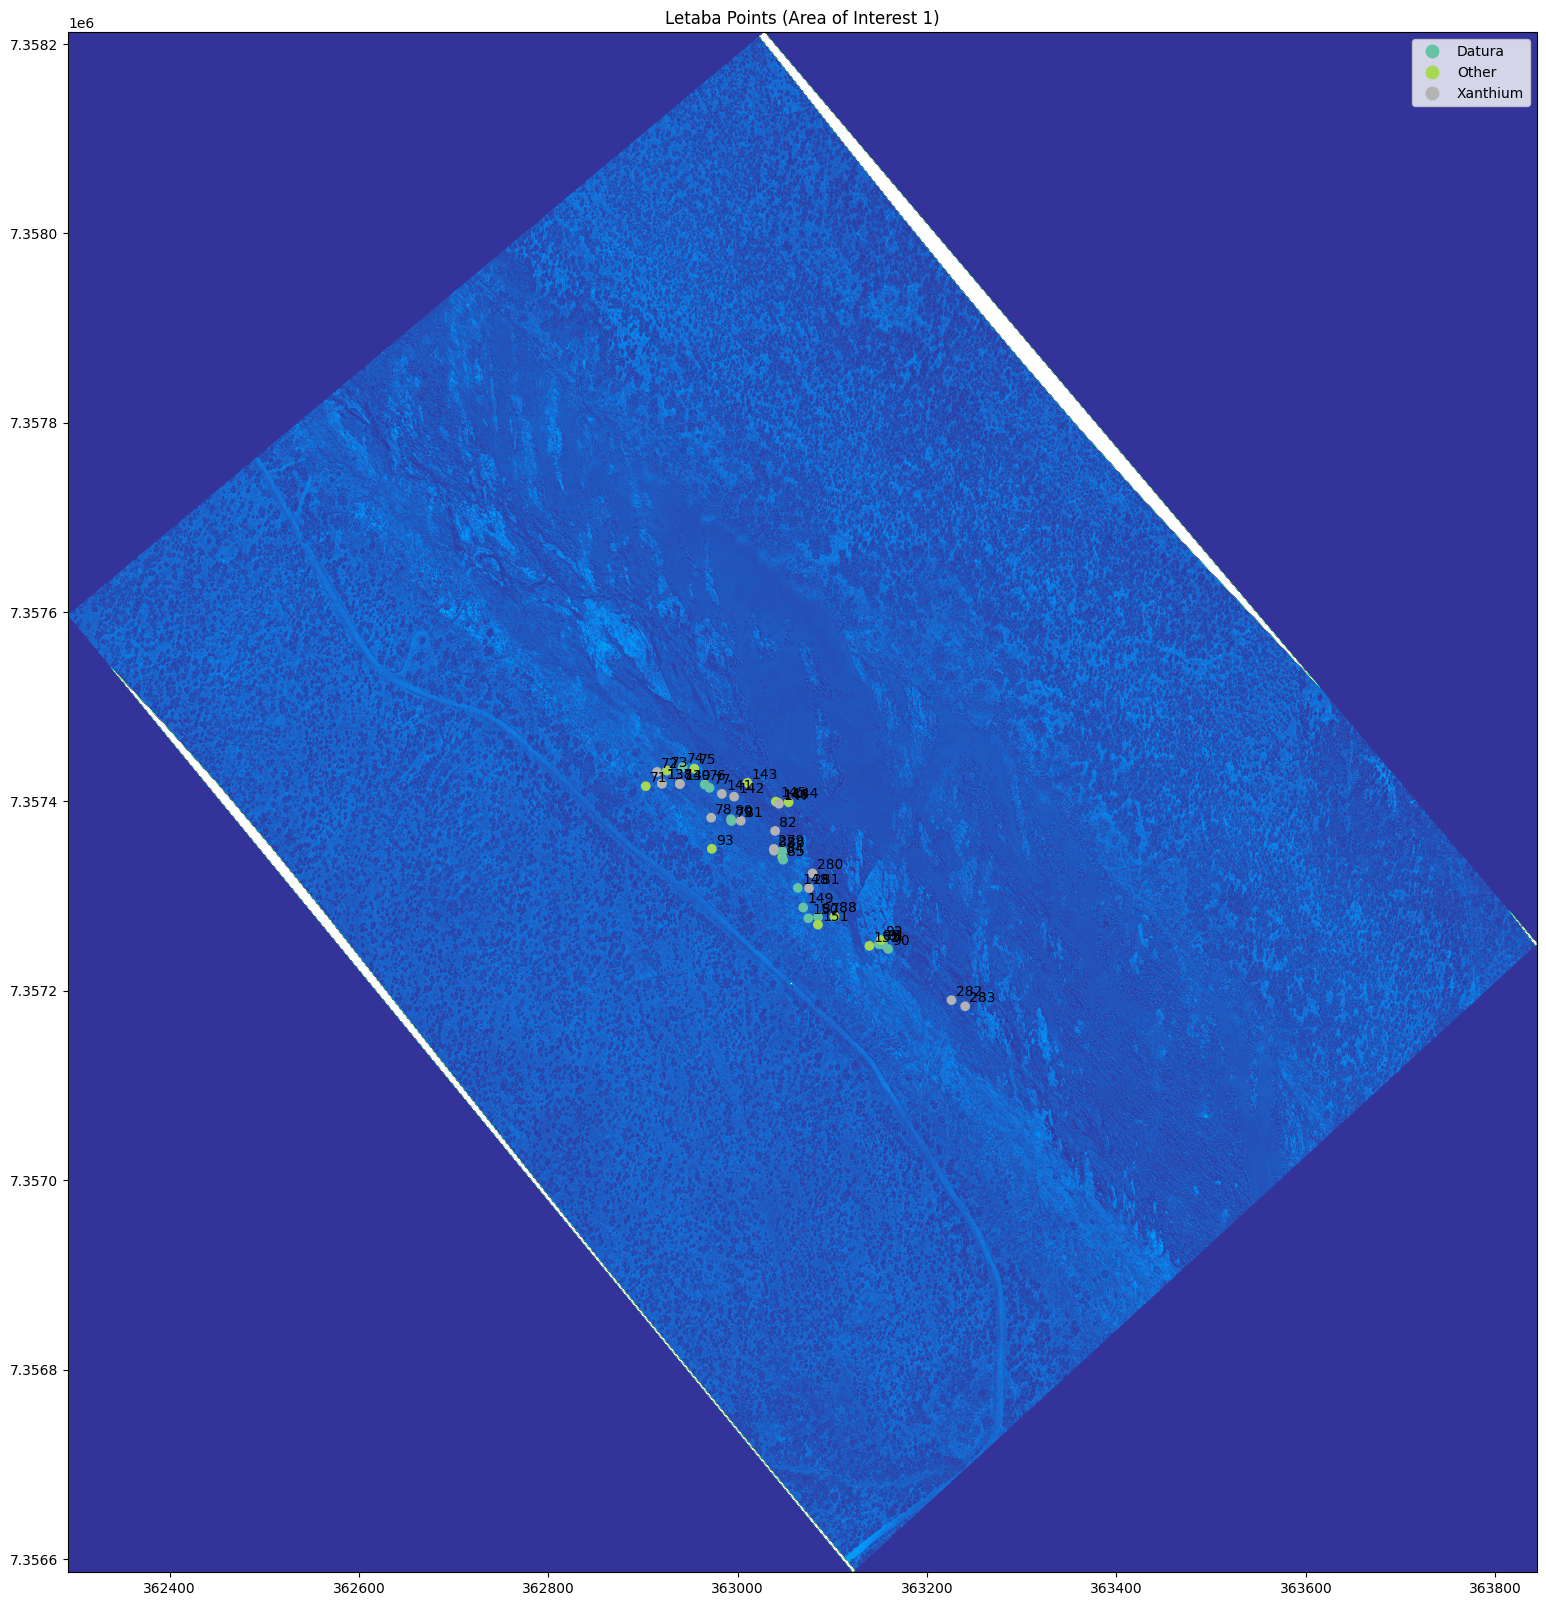

In [19]:
# plot_raster(clipped_gdf, rgba_clipped, 'rgba', 
#             out_dir=conf.data.path_rep, fn=conf.data.fn_rgba, 
#             show=False)

plot_raster(clipped_gdf, hyps_aligned_rgb, 'hyps',
            out_dir=conf.data.path_rep, fn=conf.data.fn_hyps,
            show=True)

# plot_raster(clipped_gdf, dsm_aligned, 'dsm',
#             out_dir=conf.data.path_rep, fn=conf.data.fn_dsm,
#             show=False)

# plot_raster(clipped_gdf, dtm_aligned, 'dtm',
#             out_dir=conf.data.path_rep, fn=conf.data.fn_dtm,
#             show=True)

In [ ]:
def plot_band(hyperspectral_img, band, cmap='viridis'):
    # Extract the specified band
    band_img = hyperspectral_img[band, :, :]

    # Plot the band using the specified colormap
    plt.imshow(band_img, cmap=cmap)
    plt.colorbar()
    plt.show()

In [10]:
def plot_rgb_composite(hyperspectral_img, gdf, out_dir=None, fn=None, show=False):
    # Extract the RGB bands (assuming band indexing starts at 0)
    r_band = hyperspectral_img[7, :, :]
    g_band = hyperspectral_img[4, :, :]
    b_band = hyperspectral_img[2, :, :]

    # Stack the bands to create an RGB image
    rgb_img = np.dstack((r_band, g_band, b_band))

    # Normalize each band to [0, 1] for display purposes
    rgb_img_norm = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

    # Plot the RGB composite image
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(rgb_img_norm)
    ax.set_title("RGB Composite of Hyperspectral Image")

    # Plot the GeoDataFrame on top of the RGB composite image
    gdf.plot(column='Species', categorical=True, legend=True, cmap="Set2", ax=ax, aspect=1)
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.pid):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

    # Save or show the plot
    if show:
        plt.show()
    else:
        plt.savefig(f"{out_dir}preprocessed_{fn}.png")
        print(f"Saved plot to {out_dir}preprocessed_{fn}.png")

In [13]:
# Plot the RGB composite image
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(rgb_img_norm)
ax.set_title("RGB Composite of Hyperspectral Image")

Text(0.5, 1.0, 'RGB Composite of Hyperspectral Image')

In [ ]:
plot_rgb_composite(hyps_aligned.read(), clipped_gdf, out_dir=conf.data.path_rep, fn=conf.data.fn_hyps, show=True)

In [ ]:
def change_background(rasterimg, value):
    mask = rasterimg > 0
    rasterimg[~mask] = value
    return rasterimg

In [ ]:
dtm_aligned_new = change_background(dtm_aligned.read(1), 0)

In [ ]:
def normalize(rasterimg):
    rasterimg = (rasterimg - np.min(rasterimg)) / (np.max(rasterimg) - np.min(rasterimg))
    return rasterimg

In [ ]:
dtm_new = normalize(dtm_aligned.read(1))

In [ ]:
def adjust_contrast(rasterimg, low, high):
    rasterimg = exposure.rescale_intensity(rasterimg, in_range=(low, high))
    return rasterimg

In [ ]:
dtm_new2 = adjust_contrast(dtm_aligned.read(1), 0.5, 1)

In [ ]:
def plot_raster(gdf, rasterimg, raster_type, out_dir=None, fn=None, show=False):
    fig, ax = plt.subplots(figsize = (20,20))
    # rasterio.plot.show(rasterimg, ax=ax, )
    
    # if raster_type == 'rgba':
    #     cmap = "Set2"
    if raster_type == 'hyps':
        cmap = "Set2"
    # if raster_type == 'dsm' or raster_type == 'dtm':
    #     cmap = "terrain"

    gdf.plot(column='Species',
                   categorical=True,
                   legend=True,
                   cmap="Set2",
                   ax=ax,
            aspect=1)
    ax.set_title("Letaba Points (Area of Interest 1)")
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.pid):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    if show == True:
        rasterio.plot.show(rasterimg, ax=ax, cmap=cmap)
    else:
        utils.save_plot(fig, f"{out_dir}preprocessed_{fn}.png")
        logger.info(f"Saved plot to {out_dir}preprocessed_{fn}.png")

In [ ]:
plot_raster(clipped_gdf, hyps_aligned, 'hyps',
            out_dir=conf.data.path_rep, fn=conf.data.fn_hyps,
            show=True)

In [ ]:
@utils.timer
def main():
    conf = utils.load_config("base")
    imgs, gdf = load_data(conf)

    intersecting_box = get_bbox(imgs)
    target_bounds = intersecting_box.bounds
    
    rgba_clipped = clip_raster_to_bounds('rgba', conf.data.path_int_cl, imgs['rgba'], target_bounds)
    hyps_clipped = clip_raster_to_bounds('hyps', conf.data.path_int_cl, imgs['hyps'], target_bounds)
    dsm_clipped = clip_raster_to_bounds('dsm', conf.data.path_int_cl, imgs['dsm'], target_bounds)
    dtm_clipped = clip_raster_to_bounds('dtm', conf.data.path_int_cl, imgs['dtm'], target_bounds)

    hyps_aligned = align_rasters('hyps', conf.data.path_int_al, hyps_clipped, rgba_clipped)
    dsm_aligned = align_rasters('dsm', conf.data.path_int_al, dsm_clipped, rgba_clipped)
    dtm_aligned = align_rasters('dtm', conf.data.path_int_al, dtm_clipped, rgba_clipped)

    clipped_gdf = clip_gdf(gdf, rgba_clipped.bounds)

    plot_raster(clipped_gdf, rgba_clipped, 
                out_dir=conf.data.path_rep, fn=conf.data.fn_rgba, show=False, save=True)
    plot_raster(clipped_gdf, hyps_aligned, 
                out_dir=conf.data.path_rep, fn=conf.data.fn_hyps, show=False, save=True)
    plot_raster(clipped_gdf, dsm_aligned, 
                out_dir=conf.data.path_rep, fn=conf.data.fn_dsm, show=False, save=True)
    plot_raster(clipped_gdf, dtm_aligned, 
                out_dir=conf.data.path_rep, fn=conf.data.fn_dtm, show=False, save=True)

    # chm = create_canopy_height_model('chm', conf.data.path_int_al, dsm_aligned, dtm_aligned)

    create_cropped_data(clipped_gdf, conf,
                     rgba_clipped, hyps_aligned, dsm_aligned, dtm_aligned)


# if __name__ == "__main__":
#     main()

In [29]:
import numpy as np

In [30]:
chm = np.load("../data/02_intermediate/04_cropped_imgs/71_chm_Other.npy")

In [32]:
chm.shape

(1, 87, 87)

In [33]:
chm.max()

255

In [35]:
chm.min()

0

In [36]:
chm.mean()

0.44431232659532305

In [39]:
np.median(chm)

0.0

In [47]:
chm[0].shape

(87, 87)

In [50]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalizes the pixel values of the input image to the range 0-255.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The normalized image.
    """
    normalized_image = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255
    return normalized_image.astype(np.uint8)

In [51]:
chm_norm = normalize_image(chm[0])

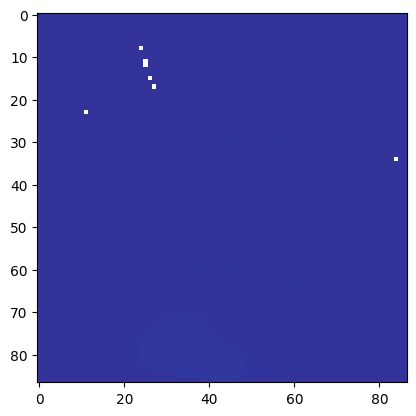

<Axes: >

In [57]:
rasterio.plot.show(chm_norm, cmap='terrain')

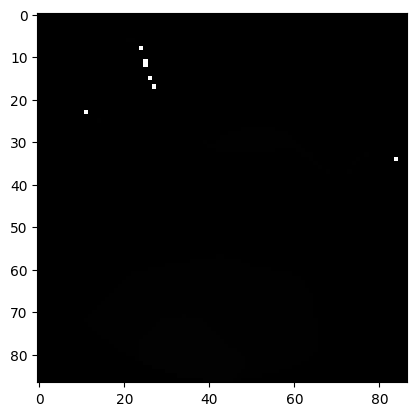

In [48]:
plt.imshow(chm[0], cmap='gray')
plt.show()